# Modelo para Detecção de Diabetes

O objetivo desse é a elaboração de um modelo capaz de prever se um paciente possui ou não diabetes, baseado em certas medições. Ou seja, temos um problema de classificação binária.

O modelo será baseado em DADOS históricos, sendo que esses dados originalmente pertence ao National Institute of Diabetes and Digestive and Kidney Diseases. Podem ser baixados através do link: https://www.kaggle.com/uciml/pima-indians-diabetes-database.

Significado de cada feature no dataset:

1. num_preg:     Number of times pregnant
2. glucose_conc: Plasma glucose concentration a 2 hours in an oral glucose tolerance test
3. diastolic_bp: Diastolic blood pressure (mmHg)
4. thickness:    Triceps skin fold thickness (mm)
5. insulin:      2-Hour serum insulin (mu U/ml)
6. bmi:          Body mass index (weight in kg/(height in m)^2)
7. diab_pred:    Diabetes pedigree function
8. age:          Age (years)
9. diabetes:     Class variable (True or False)

# Módulos

In [1]:
# módulos utilizados:

# ignorar warnings.
import warnings
warnings.filterwarnings('ignore')

# manipulação de dados:
import pandas as pd
import numpy as np

# visualização:
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image

# split do dataset em dados de treino e teste:
from sklearn.model_selection import train_test_split

# pré processamento dos dados:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import StandardScaler

# algoritmos de machine learning:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from xgboost import XGBClassifier

# otimização
from sklearn.model_selection import RandomizedSearchCV

# metricas
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

# Funções

Funções que serão utilizadas ao decorrer da criação do modelo.

In [2]:
# criar boxplot.
def box_heatmap(df, nome):
    stats = df[df[nome] > 0][[nome, 'diabetes']]
    
    print(stats.describe())
    
    fig, ax = plt.subplots(1,2, figsize = (18,8))
    sns.boxplot(y = nome, x = 'diabetes', data = stats, ax = ax[0])
    sns.heatmap(stats.corr(), annot = True, ax = ax[1])
    fig.show()
    
def displot_stats(df, nome):
    # criar um novo dataset.
    stats = df[df[nome] > 0][[nome, 'diabetes']]
    
    # recolher estatísticas para os pacientes com diabetes.
    stats_true = stats[stats.diabetes == True].describe()
    
    # recolher estatísticas para os pacientes sem diabetes.
    stats_false = stats[stats.diabetes == False].describe()
    
    # agrupar em um dataset.
    stats_concat = pd.concat([stats_true, stats_false], axis = 1)
    stats_concat.columns = ['Com Diabetes', 'Sem Diabetes']
    
    # gráfico da distribuição.
    sns.displot(stats, x = nome, hue = 'diabetes', kind = 'kde', fill = True, height = 6)
    plt.show()
    
    # imprimir as estatísticas.
    print(stats_concat)
    
def plot_comp(y_teste, previsoes):
    plt.figure(figsize=(8,6))
    ax1 = sns.distplot(y_teste, hist = False, color = "r", label = "Valores Reais")
    sns.distplot(previsoes, hist = False, color = "b", label = "Valores Previstos", ax = ax1)
    plt.legend()

# Análise Exploratória dos Dados

In [3]:
# importando o dataset.
df = pd.read_csv('pima-data.csv')
df.head(10)

,num_preg,glucose_conc,diastolic_bp,thickness,insulin,bmi,diab_pred,age,skin,diabetes
0,6,148,72,35,0,33.6,0.627,50,1.3780,True
1,1,85,66,29,0,26.6,0.351,31,1.1426,False
2,8,183,64,0,0,23.3,0.672,32,0.0000,True
3,1,89,66,23,94,28.1,0.167,21,0.9062,False
4,0,137,40,35,168,43.1,2.288,33,1.3790,True
5,5,116,74,0,0,25.6,0.201,30,0.0000,False
6,3,78,50,32,88,31.0,0.248,26,1.2608,True
7,10,115,0,0,0,35.3,0.134,29,0.0000,False
8,2,197,70,45,543,30.5,0.158,53,1.7730,True
9,8,125,96,0,0,0.0,0.232,54,0.0000,True


In [4]:
# procurando por missing values no dataset e checando os tipos de cada feature.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   num_preg      768 non-null    int64  
 1   glucose_conc  768 non-null    int64  
 2   diastolic_bp  768 non-null    int64  
 3   thickness     768 non-null    int64  
 4   insulin       768 non-null    int64  
 5   bmi           768 non-null    float64
 6   diab_pred     768 non-null    float64
 7   age           768 non-null    int64  
 8   skin          768 non-null    float64
 9   diabetes      768 non-null    bool   
dtypes: bool(1), float64(3), int64(6)
memory usage: 54.9 KB


In [5]:
# pricipais estatísticas das features.
df.describe()

,num_preg,glucose_conc,diastolic_bp,thickness,insulin,bmi,diab_pred,age,skin
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.809135
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.628516
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.906200
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.260800
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,3.900600


In [6]:
nomes = list(df.columns)
for nome in nomes:
    size = df[df[nome] == 0][nome].size
    print('Quantidade de zeros em "{}": {}.'.format(nome, size))

Quantidade de zeros em "num_preg": 111.
Quantidade de zeros em "glucose_conc": 5.
Quantidade de zeros em "diastolic_bp": 35.
Quantidade de zeros em "thickness": 227.
Quantidade de zeros em "insulin": 374.
Quantidade de zeros em "bmi": 11.
Quantidade de zeros em "diab_pred": 0.
Quantidade de zeros em "age": 0.
Quantidade de zeros em "skin": 227.
Quantidade de zeros em "diabetes": 500.


O dataset possui 768 observações e 10 colunas, sendo 9 colunas preditoras e uma coluna target. Os tipos dos dados foram importados corretamente, conforme as informações que cada coluna se prestou a indicar.

Entretanto, passando pelas linhas e colunas, foi possível encontrar features que apresentam alguns valores zerados. Podemos levantar algumas hipóteses para isso ter acontecido: esses dados não foram recolhidos ou não foram repassados corretamente para o dataset.

Para resolver esse problema irei imputar alguns valores com base em alguns critérios. Mas vou fazer esse procedimento previamente a seleção de variáveis.

In [7]:
# correlação entre as features.
cor = df.corr()
cor

,num_preg,glucose_conc,diastolic_bp,thickness,insulin,bmi,diab_pred,age,skin,diabetes
num_preg,1.000000,0.129459,0.141282,-0.081672,-0.073535,0.017683,-0.033523,0.544341,-0.081673,0.221898
glucose_conc,0.129459,1.000000,0.152590,0.057328,0.331357,0.221071,0.137337,0.263514,0.057326,0.466581
diastolic_bp,0.141282,0.152590,1.000000,0.207371,0.088933,0.281805,0.041265,0.239528,0.207371,0.065068
thickness,-0.081672,0.057328,0.207371,1.000000,0.436783,0.392573,0.183928,-0.113970,1.000000,0.074752
insulin,-0.073535,0.331357,0.088933,0.436783,1.000000,0.197859,0.185071,-0.042163,0.436785,0.130548
bmi,0.017683,0.221071,0.281805,0.392573,0.197859,1.000000,0.140647,0.036242,0.392574,0.292695
diab_pred,-0.033523,0.137337,0.041265,0.183928,0.185071,0.140647,1.000000,0.033561,0.183927,0.173844
age,0.544341,0.263514,0.239528,-0.113970,-0.042163,0.036242,0.033561,1.000000,-0.113973,0.238356
skin,-0.081673,0.057326,0.207371,1.000000,0.436785,0.392574,0.183927,-0.113973,1.000000,0.074750
diabetes,0.221898,0.466581,0.065068,0.074752,0.130548,0.292695,0.173844,0.238356,0.074750,1.000000


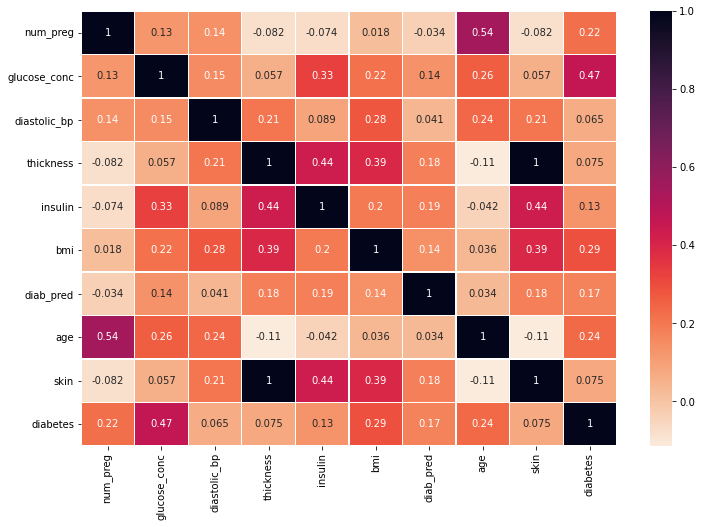

In [8]:
# heatmap da correlação.
plt.figure(figsize = (12, 8))
sns.heatmap(cor, cmap = 'rocket_r', linewidths = 0.3, annot = True)
plt.show()

O dataset possui correlações fracas entre as variáveis. Dentre as correlações encontradas, as que possuem maior grau de correlação é: número de gravidez e idade, glicemia e insulina, Dobra Cutânea Triciptal e insulina e Dobra Cutânea Triciptal e IMC.

Apesar da correlação indicar o grau entre o relacionamento entre duas variáveis, esta não implica em causalidade.

## Glicemia

A glicemia é a concentração de glicose no sangue ou mais precisamente no plasma.

O nosso corpo transforma alguns dos hidratos de carbono ingeridos em glicose e a glicemia é o nível de glicose presente no nosso sangue. Ou seja, quando comemos muito, a glicemia aumenta, ao passo que quando comemos pouco, esta mantém-se baixa. 

Mede-se a glicemia através da confirmação dos sinais e sintomas clássicos da glicemia em jejum (exame de sangue onde são verificadas as taxas de glicose no sangue) e do teste padronizado de tolerância à glicose (TTG).

Estes critérios diagnosticados estão baseados nas recomendações da comunidade médico-científica atual:

* Normal: Abaixo de 100 mg/dL;
* Intolerância à glicose: jejum de 111 a 125 mg/dL; 2 horas após 75g de glicose: de 141 a 199 mg/dL;
* Diabetes melitus: jejum maior que 126 mg/dL; 2 horas após 75g de glicose: maior que 200 mg/dL.

Tanto a média quanto a mediana para os sem diabetes é ligeiramente inferior aos pacientes que possuem diabetes. A correlação entre glicemia e diabetes é moderada fraca (0.47).

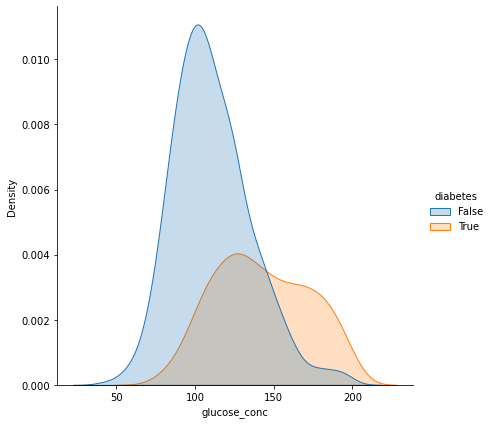

       Com Diabetes  Sem Diabetes
count    266.000000    497.000000
mean     142.319549    110.643863
std       29.599199     24.776906
min       78.000000     44.000000
25%      119.000000     93.000000
50%      140.000000    107.000000
75%      167.000000    125.000000
max      199.000000    197.000000


In [9]:
displot_stats(df, 'glucose_conc')

## Pressão Sanguínea Diastólica

Pressão arterial diastólica (PAD) é o menor valor verificado durante a aferição de pressão arterial. Exemplo: 120x80; em que 120 refere-se à pressão arterial sistólica e 80 refere-se à pressão arterial diastólica, ambas medidas em milímetros de mercúrio (mmHg). Esta aferição refere-se à pressão exercida pelo sangue nas paredes da aorta durante a Diástole ventricular (Diástole Ventricular é o movimento de "relaxamento" dos ventrículos, em que eles se expandem (relaxam), permitindo que o Sangue que foi impulsionado pelos Átrios encha os Ventrículos.). 

A pressão diastólica recomendada para um adulto normal é de 80 mmHg.

* Hipotensão se a leitura sistólica for < 90 mmHg e a leitura diastólica for < 60 mmHg;
* Pré-hipertensão se a leitura sistólica for de 121 a 139 mmHg e a leitura diastólica for de 81 a 89 mmHg;
* Hipertensão estágio 1 se a leitura sistólica for 140 a 159 mmHg e a leitura diastólica for 90 a 99 mmHg;
* Hipertensão estágio 2 se a leitura sistólica é de 160 mmHg e a leitura diastólica é de 100 mmHg.

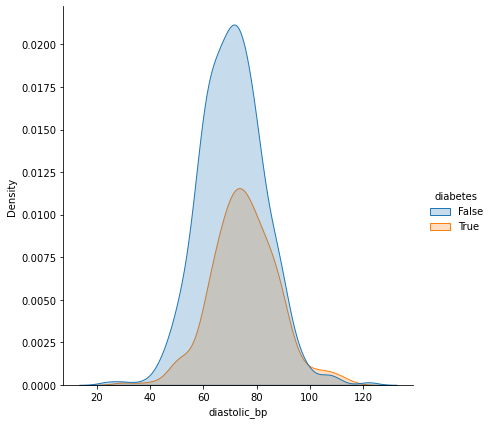

       Com Diabetes  Sem Diabetes
count    252.000000    481.000000
mean      75.321429     70.877339
std       12.299866     12.161223
min       30.000000     24.000000
25%       68.000000     62.000000
50%       74.500000     70.000000
75%       84.000000     78.000000
max      114.000000    122.000000


In [10]:
displot_stats(df, 'diastolic_bp')

## Dobra Cutânea Triciptal

É medida na face posterior do braço, paralelamente ao eixo longitudinal, no ponto que compreende a metade da distância entre a borda súpero-lateral do acrômio e o olécrano.

A espessura da dobra cutânea tricipal e de um diagnóstico positivo para diabetes apresenta uma correlação positiva fraca. Os valores, já no primeiro quartil para os pacientes com e sem diabetes já distoam bastante.

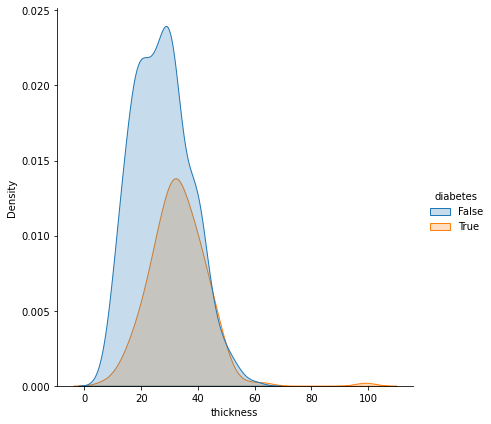

       Com Diabetes  Sem Diabetes
count    180.000000    361.000000
mean      33.000000     27.235457
std       10.327595     10.026491
min        7.000000      7.000000
25%       27.000000     19.000000
50%       32.000000     27.000000
75%       39.000000     33.000000
max       99.000000     60.000000


In [11]:
displot_stats(df, 'thickness')

## IMC

O índice de massa corporal (IMC) é uma medida internacional usada para calcular se uma pessoa está no peso ideal. Em adultos:

* Abaixo de 17:	muito abaixo do peso
* Entre 17 e 18.49:	abaixo do peso
* Entre 18.50 e 24.99:	peso normal
* Entre 25 e 29.99:	acima do peso
* Entre 30 e 34.99:	obesidade I
* Entre 35 e 39.99:	obesidade II (severa)
* Acima de 40:	obesidade III (mórbida)

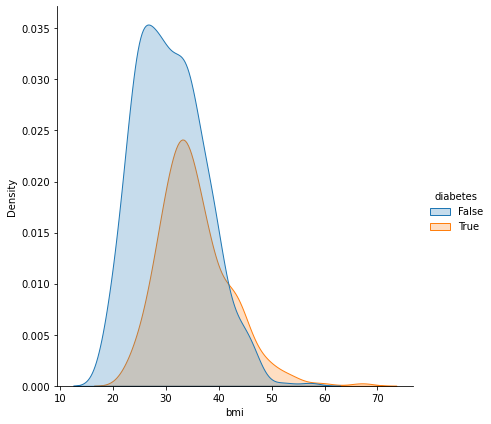

       Com Diabetes  Sem Diabetes
count    266.000000    491.000000
mean      35.406767     30.859674
std        6.614982      6.560737
min       22.900000     18.200000
25%       30.900000     25.600000
50%       34.300000     30.100000
75%       38.925000     35.300000
max       67.100000     57.300000


In [12]:
displot_stats(df, 'bmi')

## Diabetes Pedigree Function (DPF)

Esse índice fornece uma síntese histórica de diabetes em parentes e a relação genética desses parentes com o sujeito investigado. Este utiliza informações de pais, avós, irmãos, tias, tios e primos de primeiro grau. Ele fornece uma medida da influência genética esperada de parentes afetados e não afetados no eventual risco de diabetes do sujeito.

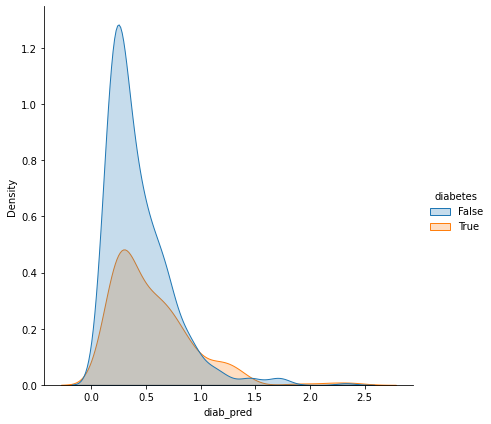

       Com Diabetes  Sem Diabetes
count    268.000000    500.000000
mean       0.550500      0.429734
std        0.372354      0.299085
min        0.088000      0.078000
25%        0.262500      0.229750
50%        0.449000      0.336000
75%        0.728000      0.561750
max        2.420000      2.329000


In [13]:
displot_stats(df, 'diab_pred')

## Idade

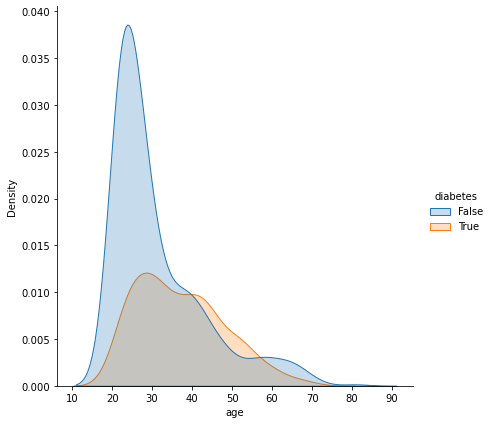

       Com Diabetes  Sem Diabetes
count    268.000000    500.000000
mean      37.067164     31.190000
std       10.968254     11.667655
min       21.000000     21.000000
25%       28.000000     23.000000
50%       36.000000     27.000000
75%       44.000000     37.000000
max       70.000000     81.000000


In [14]:
displot_stats(df, 'age')

## Insulina

A insulina é um hormônio produzido pelo pâncreas. Esse hormônio avisa as células do organismo para que absorvam a glicose

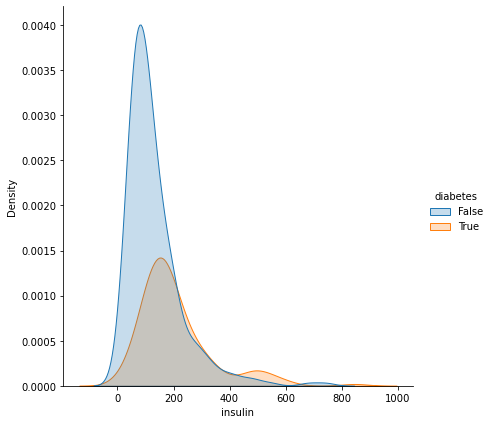

       Com Diabetes  Sem Diabetes
count    130.000000    264.000000
mean     206.846154    130.287879
std      132.699898    102.482237
min       14.000000     15.000000
25%      127.500000     66.000000
50%      169.500000    102.500000
75%      239.250000    161.250000
max      846.000000    744.000000


In [15]:
displot_stats(df, 'insulin')

# Seleção de Variáveis

A correlação máxima (1) entre as features skin e thickness indica que ambas podem representar informações semelhantes para a previsão de diabetes. Ou seja, podemos remover uma ou outra sem o prejuízo de perda de informações para o treinamento do modelo.

Mas, antes de selecionar as variáveis para o modelo. Chegou a hora de inputar valores para substituir os valores zerados no nosso dataset.

* Quantidade de zeros em "glucose_conc": 5.
* Quantidade de zeros em "diastolic_bp": 35.
* Quantidade de zeros em "thickness": 227.
* Quantidade de zeros em "insulin": 374.
* Quantidade de zeros em "bmi": 11.
* Quantidade de zeros em "skin": 227.

Para isso, vou utilizar um critério. Irei separar as variáveis em dois grupos, com diabetes e sem diabetes, e a partir desses dois grupos irei tirar a média. Essa média será utilizada para substituir os valores zerados para cada variável e cada grupo.

In [16]:
# novo dataframe
newdf = df.copy()

# glicemia
mean_gluc_true = newdf[(df.glucose_conc > 0) & (newdf.diabetes == True)]['glucose_conc'].mean()
mean_gluc_false = newdf[(df.glucose_conc > 0) & (newdf.diabetes == False)]['glucose_conc'].mean()
newdf.loc[(newdf.glucose_conc == 0) & (newdf.diabetes == True), 'glucose_conc'] = mean_gluc_true
newdf.loc[(newdf.glucose_conc == 0) & (newdf.diabetes == False), 'glucose_conc'] = mean_gluc_false

# diastolic
mean_dias_true = newdf[(newdf.diastolic_bp > 0) & (newdf.diabetes == True)]['diastolic_bp'].mean()
mean_dias_false = newdf[(newdf.diastolic_bp > 0) & (newdf.diabetes == False)]['diastolic_bp'].mean()
newdf.loc[(newdf.diastolic_bp == 0) & (newdf.diabetes == True), 'diastolic_bp'] = mean_dias_true
newdf.loc[(newdf.diastolic_bp == 0) & (newdf.diabetes == False), 'diastolic_bp'] = mean_dias_false

# thickness
mean_thickness_true = newdf[(newdf.thickness > 0) & (newdf.diabetes == True)]['thickness'].mean()
mean_thickness_false = newdf[(newdf.thickness > 0) & (newdf.diabetes == False)]['thickness'].mean()
newdf.loc[(newdf.thickness == 0) & (newdf.diabetes == True), 'thickness'] = mean_thickness_true
newdf.loc[(newdf.thickness == 0) & (newdf.diabetes == False), 'thickness'] = mean_thickness_false

# skin
mean_skin_true = newdf[(newdf.skin > 0) & (newdf.diabetes == True)]['skin'].mean()
mean_skin_false = newdf[(newdf.skin > 0) & (newdf.diabetes == False)]['skin'].mean()
newdf.loc[(newdf.skin == 0) & (newdf.diabetes == True), 'skin'] = mean_skin_true
newdf.loc[(newdf.skin == 0) & (newdf.diabetes == False), 'skin'] = mean_skin_false

# insulin
mean_insulin_true = newdf[(newdf.insulin > 0) & (newdf.diabetes == True)]['insulin'].mean()
mean_insulin_false = newdf[(newdf.insulin > 0) & (newdf.diabetes == False)]['insulin'].mean()
newdf.loc[(newdf.insulin == 0) & (newdf.diabetes == True), 'insulin'] = mean_insulin_true
newdf.loc[(newdf.insulin == 0) & (newdf.diabetes == False), 'insulin'] = mean_insulin_false

# bmi
mean_bmi_true = newdf[(newdf.bmi > 0) & (df.diabetes == True)]['bmi'].mean()
mean_bmi_false = newdf[(newdf.bmi > 0) & (df.diabetes == False)]['bmi'].mean()
newdf.loc[(newdf.bmi == 0) & (newdf.diabetes == True), 'bmi'] = mean_bmi_true
newdf.loc[(newdf.bmi == 0) & (newdf.diabetes == False), 'bmi'] = mean_bmi_false

In [17]:
nomes = list(newdf.iloc[:, 1:9].columns)
for nome in nomes:
    size = newdf[newdf[nome] == 0][nome].size
    print('Quantidade de zeros em "{}": {}.'.format(nome, size))

Quantidade de zeros em "glucose_conc": 0.
Quantidade de zeros em "diastolic_bp": 0.
Quantidade de zeros em "thickness": 0.
Quantidade de zeros em "insulin": 0.
Quantidade de zeros em "bmi": 0.
Quantidade de zeros em "diab_pred": 0.
Quantidade de zeros em "age": 0.
Quantidade de zeros em "skin": 0.


Zeros removidos com sucesso.

Respeitando o princípio de Occam's razor, que diz que explicações mais simples sobre um fenômeno observado devem se sobressair sobre explicações mais complexas, vamos selecionar nossas variáveis. Com isso, iremos evitar a maldição da dimensonalidade e tornar nosso modelo o mais generalizado possível, evitando overfitting.

Existem várias técnicas para a seleção de variáveis, tais como: seleção univariada, eliminação recursiva de atributos, random forest e entre outros. Para esse caso, será utilizado o algoritmo Random Forest. Esse algoritmo atribui uma pontuação de acordo com o grau de importância da variável para a predição do modelo.

In [18]:
# seleção de variáveis.
# excluíndo a variável skin.
x = newdf.iloc[:, 0:8]
y = newdf.iloc[:, 9]

# criação do modelo.
modelo_selec_var = ExtraTreesClassifier()
modelo_selec_var.fit(x, y)

# resultados.
resultado = pd.DataFrame({'Colunas' : newdf.columns[0:8], 
              'Pontuacao' : modelo_selec_var.feature_importances_}).sort_values('Pontuacao', ascending = False).reset_index(drop = True)

# caputurando as 6 maiores pontuações.
features = list(resultado.iloc[0:5, 0])

# imprindo as pontuações.
resultado

,Colunas,Pontuacao
0,insulin,0.250157
1,glucose_conc,0.191921
2,thickness,0.127653
3,bmi,0.105123
4,age,0.099087
5,diab_pred,0.083217
6,num_preg,0.076866
7,diastolic_bp,0.065976


Note que a insulina recebeu a maior pontuação dentre as variáveis. Sendo que, ela também recebeu a maior carga de substituição de valores ausentes (quase 50%), o que pode ter influenciado na sua pontuação. Vou retirar todos os valores zerados do dataset e refazer as pontuações.

In [19]:
# Dataset com valores de insulina diferente de 0.
hipotese = df[df.insulin > 0]

# excluíndo a variável skin.
x = hipotese.iloc[:, 0:8]
y = hipotese.iloc[:, 9]

# criação do modelo.
modelo_selec_var = ExtraTreesClassifier()
modelo_selec_var.fit(x, y)

# resultados.
resultado = pd.DataFrame({'Colunas' : newdf.columns[0:8], 
              'Pontuacao' : modelo_selec_var.feature_importances_}).sort_values('Pontuacao', ascending = False).reset_index(drop = True)

resultado

,Colunas,Pontuacao
0,glucose_conc,0.212568
1,age,0.141953
2,insulin,0.126168
3,bmi,0.111047
4,diab_pred,0.110549
5,num_preg,0.107940
6,thickness,0.101171
7,diastolic_bp,0.088603


Para esse novo dataset a glicemia tornou-se a variável com maior pontuação. A insulina passou a ser apenas a terceira variável em grau de importância para a predição. Porém, vamos utilizar o dataset tratado para realizar treinamento do nosso modelo.

Para o nosso modelo vamos utilizar as variáveis com as 5 maiores pontuações: 'insulin', 'glucose_conc', 'thickness', 'bmi' e 'age'.

# Construção do Modelo

Será construído vários modelos de classificação para comparar qual o melhor algoritmo para a execução da tarefa. Primeiramente vou utilizar o dataset sem qualquer tratamento dos dados, para posteriormente ver qual o ganho com os dados tratados e transformados.

## Separação em Dados de Treino e Teste

Vou fazer a separação para o dataset bruto e para o dataset que recebeu os valores no lugar dos zeros com feature selection.

In [20]:
# split dos dados em dados de treino e dados de teste.
x_treino, x_teste, y_treino, y_teste = train_test_split(newdf[features], newdf['diabetes'], test_size = 0.3, random_state = 123)

# split dos dados em dados de treino e dados de teste para o dataset bruno.
x_treino2, x_teste2, y_treino2, y_teste2 = train_test_split(df.iloc[:, 0:9], df['diabetes'], test_size = 0.3, random_state = 123)

## Treinamento do Modelo (Dados Brutos)

In [21]:
# treinamento de vários modelos.

# lista com todos os modelos.
modelos = []

modelos.append(('RF', RandomForestClassifier()))
modelos.append(('LR', LogisticRegression()))
modelos.append(('LDA', LinearDiscriminantAnalysis()))
modelos.append(('NB', GaussianNB()))
modelos.append(('KNN', KNeighborsClassifier()))
modelos.append(('SVM', SVC()))
modelos.append(('XGB', XGBClassifier()))

# treinamento
acuracia1 = []

for nome, modelo in modelos:
    modelo.fit(x_treino2, y_treino2)
    acc = round(100 * modelo.score(x_teste2, y_teste2), 2)
    acuracia1.append((nome, acc))

for nome, acuracia in acuracia1:
    print('O modelo {} apresentou uma acurácia de {}%.'.format(nome, acuracia))

O modelo RF apresentou uma acurácia de 78.35%.
O modelo LR apresentou uma acurácia de 80.09%.
O modelo LDA apresentou uma acurácia de 81.39%.
O modelo NB apresentou uma acurácia de 76.62%.
O modelo KNN apresentou uma acurácia de 72.73%.
O modelo SVM apresentou uma acurácia de 77.49%.
O modelo XGB apresentou uma acurácia de 75.76%.


## Treinamento dos Modelos (Dados Sem Transformação)

In [22]:
# treinamento
acuracia2 = []

for nome, modelo in modelos:
    modelo.fit(x_treino, y_treino)
    acc = round(100 * modelo.score(x_teste, y_teste), 2)
    acuracia2.append((nome, acc))

for nome, acuracia in acuracia2:
    print('O modelo {} apresentou uma acurácia de {}%.'.format(nome, acuracia))

O modelo RF apresentou uma acurácia de 89.61%.
O modelo LR apresentou uma acurácia de 80.52%.
O modelo LDA apresentou uma acurácia de 81.39%.
O modelo NB apresentou uma acurácia de 82.25%.
O modelo KNN apresentou uma acurácia de 83.98%.
O modelo SVM apresentou uma acurácia de 85.71%.
O modelo XGB apresentou uma acurácia de 90.91%.


## Treinamento dos Modelos (Dados com Transformação)

O ato de transformação dos dados serve para que o algoritmo não fique enviesado devidos a diferença de escala entre os valores das variáveis. Além disso, alguns algoritmos esperam receber os dados em uma mesma escala ou em distribuição normal.

Vou fazer três tipos de transformação nos dados: normalização com MinMaxScaler() e Normalizer() e padronização com StandardScale(). No final irei comparar e escolher o com maior acuária.

A normalização transforma os dados para que eles fiquem dentro de um range, que nesse caso será de 0 à 1. A padronização transforma nossos dados para uma distribuição Gaussiana (normal) com média = 0 e desvio padrão = 1.

### Normalização (MinMaxScaler)

In [23]:
# aplicar a normalização nos dados já separados
norm1 = MinMaxScaler(feature_range = (0, 1))
x_treino_norm1 = norm1.fit_transform(x_treino)
x_teste_norm1 = norm1.fit_transform(x_teste)

# treinamento
acuracia3 = []

for nome, modelo in modelos:
    modelo.fit(x_treino_norm1, y_treino)
    acc = round(100 * modelo.score(x_teste_norm1, y_teste), 2)
    acuracia3.append((nome, acc))

for nome, acuracia in acuracia3:
    print('O modelo {} apresentou uma acurácia de {}%.'.format(nome, acuracia))

O modelo RF apresentou uma acurácia de 83.12%.
O modelo LR apresentou uma acurácia de 74.46%.
O modelo LDA apresentou uma acurácia de 75.76%.
O modelo NB apresentou uma acurácia de 75.32%.
O modelo KNN apresentou uma acurácia de 71.86%.
O modelo SVM apresentou uma acurácia de 74.03%.
O modelo XGB apresentou uma acurácia de 80.95%.


### Normalização (Normalizer)

In [24]:
# aplicar a normalização nos dados já separados
norm2 = Normalizer().fit(x_treino)
x_treino_norm2 = norm2.transform(x_treino)
x_teste_norm2 = norm2.transform(x_teste)

# treinamento
acuracia4 = []

for nome, modelo in modelos:
    modelo.fit(x_treino_norm2, y_treino)
    acc = round(100 * modelo.score(x_teste_norm2, y_teste), 2)
    acuracia4.append((nome, acc))

for nome, acuracia in acuracia4:
    print('O modelo {} apresentou uma acurácia de {}%.'.format(nome, acuracia))

O modelo RF apresentou uma acurácia de 74.89%.
O modelo LR apresentou uma acurácia de 62.34%.
O modelo LDA apresentou uma acurácia de 64.5%.
O modelo NB apresentou uma acurácia de 73.16%.
O modelo KNN apresentou uma acurácia de 76.19%.
O modelo SVM apresentou uma acurácia de 61.9%.
O modelo XGB apresentou uma acurácia de 73.16%.


### Padronização (StandardScale)

In [25]:
# aplicar a normalização nos dados já separados
norm3 = StandardScaler().fit(x_treino)
x_treino_norm3 = norm3.transform(x_treino)
x_teste_norm3 = norm3.transform(x_teste)

# treinamento
acuracia5 = []

for nome, modelo in modelos:
    modelo.fit(x_treino_norm3, y_treino)
    acc = round(100 * modelo.score(x_teste_norm3, y_teste), 2)
    acuracia5.append((nome, acc))

for nome, acuracia in acuracia5:
    print('O modelo {} apresentou uma acurácia de {}%.'.format(nome, acuracia))

O modelo RF apresentou uma acurácia de 89.61%.
O modelo LR apresentou uma acurácia de 80.52%.
O modelo LDA apresentou uma acurácia de 81.39%.
O modelo NB apresentou uma acurácia de 82.25%.
O modelo KNN apresentou uma acurácia de 87.01%.
O modelo SVM apresentou uma acurácia de 87.45%.
O modelo XGB apresentou uma acurácia de 90.91%.


Com as transformações dos dados conseguimos melhorar muito a acurácia do modelo em relação ao modelo com o dataset bruto. Os modelos baseados em Random Forest e XGBoost apresentaram as melhores acurácias dentre o todos.

# Otimizando o Modelo

Irei realizar um processo de otimização do algoritmo, buscando aumentar ainda mais a acurácia do modelo. Irei realizar esse procedimento nos dois algoritmos que apresentaram maior acurácia até o momento.

## XGBoost Tuning

In [26]:
# hyperparâmetros e seus valores que serão utilizados para testar o modelo.
hyper = {'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]}

# modelo.
modelo = XGBClassifier(learning_rate = 0.02, n_estimators = 600, objective = 'binary:logistic', silent = True, nthread = 1)

# criando o otimizador.
tuning = RandomizedSearchCV(estimator = modelo, 
                            param_distributions = hyper,
                            n_iter = 15,
                            random_state = 123,
                            scoring = 'roc_auc')

# rodando o otimizador.
tuning.fit(x_treino, y_treino)

# resultado.
print('Acurácia: {}%'.format(tuning.best_score_ * 100))
print('Melhores Parâmetros do Modelo: \n', tuning.best_estimator_)

[13:45:30] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:45:30] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:45:30] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings bu

[13:45:32] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:45:32] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:45:32] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings bu

[13:45:34] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:45:34] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:45:34] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings bu

[13:45:37] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:45:37] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:45:37] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings bu

[13:45:38] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.



Confusion Matrix:
 [[134   9]
 [ 10  78]]

Relatório de Classificação:
               precision    recall  f1-score   support

       False       0.93      0.94      0.93       143
        True       0.90      0.89      0.89        88

    accuracy                           0.92       231
   macro avg       0.91      0.91      0.91       231
weighted avg       0.92      0.92      0.92       231



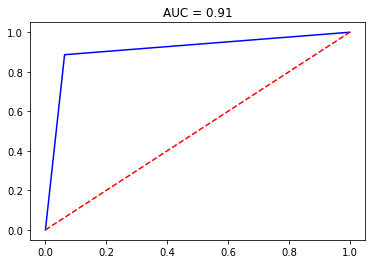

In [27]:
# modelo otimizado
modelo_otimizado1 = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1.0, gamma=1, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.02, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing = np.nan, monotone_constraints='()',
              n_estimators=600, n_jobs=1, nthread=1, num_parallel_tree=1,
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              silent=True, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)

# treinamento
modelo_otimizado1.fit(x_treino, y_treino)

# previsões
y_hat1 = modelo_otimizado1.predict(x_teste)

# confusion matrix
conf_mtx1 = confusion_matrix(y_teste, y_hat1)
class_report1 = classification_report(y_teste, y_hat1)
print('\nConfusion Matrix:\n', conf_mtx1)
print('\nRelatório de Classificação:\n', class_report1)

# curva roc
fpr1, tpr1, x = roc_curve(y_teste, y_hat1)
roc_auc1 = auc(fpr1, tpr1)

plt.title('AUC = %0.2f' % roc_auc1)
plt.plot(fpr1, tpr1, 'b')
plt.plot([0, 1], [0, 1],'r--')
plt.show()

A otimização nesse caso melhou o nosso algoritmo em um pouco mais de 1%, saindo de 89.61% para 92%. 

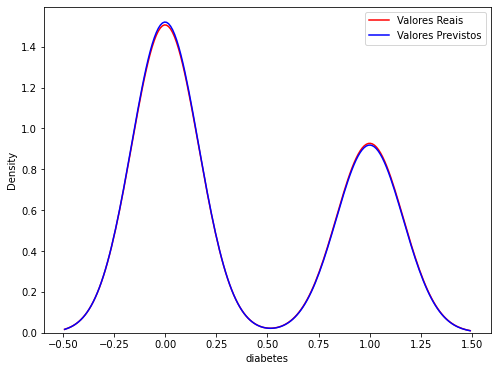

In [28]:
plot_comp(y_teste, y_hat1)

## Random Forest

In [29]:
# hyperparâmetros e seus valores que serão utilizados para testar o modelo.
hyper = {'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

# modelo.
modelo = RandomForestClassifier()

# otimizador.
tuning = RandomizedSearchCV(estimator = modelo, 
                            param_distributions = hyper,
                            n_iter = 14,
                            random_state = 123,
                            scoring = 'roc_auc')

# rodando o otimizador.
tuning.fit(x_treino, y_treino)

# resultado.
print('Acurácia: {}%'.format(tuning.best_score_ * 100))
print('Melhores Parâmetros do Modelo: \n', tuning.best_estimator_)

Acurácia: 92.98915406016344%
Melhores Parâmetros do Modelo: 
 RandomForestClassifier(bootstrap=False, max_depth=10, max_features='sqrt',
                       min_samples_leaf=4, min_samples_split=10,
                       n_estimators=1000)



Confusion Matrix:
 [[134   9]
 [ 12  76]]

Relatório de Classificação:
               precision    recall  f1-score   support

       False       0.92      0.94      0.93       143
        True       0.89      0.86      0.88        88

    accuracy                           0.91       231
   macro avg       0.91      0.90      0.90       231
weighted avg       0.91      0.91      0.91       231



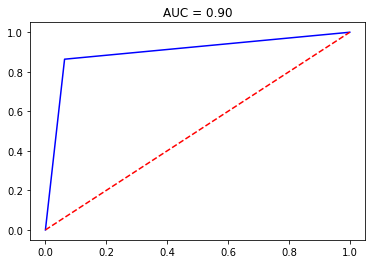

In [30]:
# modelo otimizado
modelo_otimizado2 = RandomForestClassifier(bootstrap=False, max_depth=100, min_samples_leaf=4,
                       n_estimators=1600)

# treinamento
modelo_otimizado2.fit(x_treino, y_treino)

# previsões
y_hat2 = modelo_otimizado2.predict(x_teste)

# confusion matrix
conf_mtx2 = confusion_matrix(y_teste, y_hat2)
class_report2 = classification_report(y_teste, y_hat2)
print('\nConfusion Matrix:\n', conf_mtx2)
print('\nRelatório de Classificação:\n', class_report2)

# curva roc
fpr2, tpr2, x = roc_curve(y_teste, y_hat2)
roc_auc2 = auc(fpr2, tpr2)

plt.title('AUC = %0.2f' % roc_auc2)
plt.plot(fpr2, tpr2, 'b')
plt.plot([0, 1], [0, 1],'r--')
plt.show()

Não conseguimos melhorar nosso algoritmo utilizando Random Forest. Porém, não perdemos acurácia.

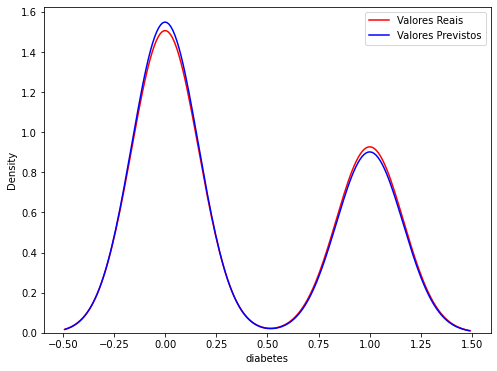

In [31]:
plot_comp(y_teste, y_hat2)

# Conclusões

- O modelo possui baixa correlação entre as variáveis preditora e a variável target. Porém, a correlação mostrou-se um bom estimador das melhores variáveis para o nosso algoritmo comparando-a com a seleção de variáveis utilziando Random Forest.


- A acurácia do dataset que recebeu o tratamento das variáveis ausentes em comparação com o dataset bruto é bem maior. O critério utilizado para imputar os novos valores pareceu bastante adequado para resolver nosso problema.


- A imputação dos valores ausentes provocou um enviesamente que beneficiou a insulina como maior variável preditora.


- Random Forest e XGBoost foram os algortimos que apresentaram maior acurácia em praticamente todas as situações.